# RSE

In [1]:
import os
import warnings
import signal
import numpy as np
import torch
import torch.nn as nn
import torch_optimizer
import matplotlib.pyplot as plt
from time import time
from musicnet_dataset import MusicNet
from musicnet_model import MusicNetModel
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import average_precision_score

c:\Users\spec3\anaconda3\envs\dgdg\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
N_EPOCHS = 100
EPOCH_SIZE = 2_000
EVAL_SIZE = 1_000
BATCH_SIZE = 4
SMOOTH = 0.1
kwargs = {'pin_memory': True}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

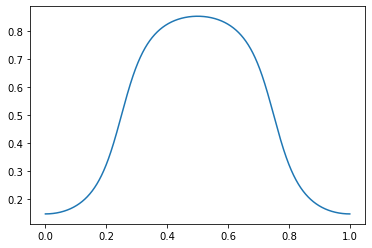

In [3]:
def get_weights(n=2048, delta=0.1):
    xs = np.linspace(-0.25, 0.75, 2048)
    ys = 1 / np.pi * np.arctan(np.sin(2*np.pi*xs) / delta) + 0.5
    return torch.tensor(ys)

plt.plot(np.linspace(0, 1, 2048), get_weights(delta=0.5));

In [5]:
with MusicNet('./data', train=True, download=True, window=8192, epoch_size=EPOCH_SIZE, pitch_shift=64) as train_dataset,\
    MusicNet('./data', train=False, download=True, window=8192, epoch_size=EVAL_SIZE, pitch_shift=64) as test_dataset:

    model = MusicNetModel()
    model.to(device)

    optimizer = torch_optimizer.RAdam(model.parameters(), lr=0.00125*np.sqrt(0.5))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

    loss_fn = nn.BCEWithLogitsLoss(reduction='none', pos_weight=torch.ones([128])*50)
    loss_fn.to(device)

    weights = get_weights(n=2048, delta=0.5).to(device)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True, **kwargs)

    for epoch in range(N_EPOCHS):

        t = tqdm(train_loader, total=EPOCH_SIZE // BATCH_SIZE, desc=f"Train. Epoch {epoch}, loss:")
        losses = []
        model.train()
        for inputs, targets in t:
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(-2).to(device))
            targets = targets[:, ::4, :]
            targets = (1 - SMOOTH*2) * targets + SMOOTH  # Label smoothing
            loss = loss_fn(outputs, targets.to(device))
            loss = (loss.permute(0, 2, 1) * weights).mean()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            t.set_description(f"Train. Epoch {epoch}, loss: {np.mean(losses[-100:]):.3f}")
        scheduler.step()

        t = tqdm(test_loader, total=EVAL_SIZE // BATCH_SIZE, desc=f"Validation. Epoch {epoch}.", leave=False)

        all_targets = []
        all_preds = []

        model.eval()
        for inputs, targets in t:
            with torch.no_grad():
                outputs = model(inputs.unsqueeze(-2).to(device))
                outputs = outputs[:, 1024, :].squeeze(1)
                targets = targets[:, 4096, :].squeeze(1)
                all_targets += list(targets.numpy())
                all_preds += list(outputs.detach().cpu().numpy())

        targets_np = np.array(all_targets)
        preds_np = np.array(all_preds)
        mask = targets_np.sum(axis=0) > 0

        print(f"Epoch {epoch}. APS: {average_precision_score(targets_np[:, mask], preds_np[:, mask]) : .2%}.")